# Tutorial for `SCOTT`: Breakdown of intermediate functionalities

The goal of this package is to provide a topological toolkit for comparing distributions of graphs based on their underlying curvature.

Quantifying the dissimilarity between distributions of graphs can be accomplished in several lines of code using our `Comparator` object. See `example.py` and our tutorial on how to customize this process: `custom_compare.ipynb`.

For those who are interested in isolating the intermediate functionalities required for finding this distance, we offer the following tutorial.

## Workflow / BagPipeline

Here is a general overview of the underlying workflow, or **BagPipeline**, if you will. Steps follow Figure 1 below from left to right.

![Bagpipeline for computing distance between graphs based on curvature filtrations.](assets/bagpipeline_ohne_text.png)
*Figure 1 from [Curvature Filtrations for Graph Generative Model Evaluation](https://arxiv.org/abs/2301.12906)*

1. Our objects of interest are graphs, denoted G=(V,E), made up of a set of nodes (V) and a set of pairwise edges between nodes (E). We can compare either individual graphs or distributions (lists) of graphs.

2. We compute curvature with our `KILT` object, assigning a curvature value to each edge. This is what we call our **geometry** step.
    The `KILT` object allows the user to customize the method they want to use for computing curvature. Currently, `KILT` supports "foreman_curvature", "balanced_forman_curvature", "ollivier_ricci_curvature", and "resistance_curvature".

3. We then use the `GraphHomology` object to compute a filtration on the edges based on their curvature values. This is what we call our **topology** step.

4. The output of this filtration is a persistence diagram, which consists of (birth, death) persistence pairs for each of the homology dimensions (shown here with H0 in red and H1 in blue). However, persistence diagrams are not able to be compared easily, and thus require a vectorization scheme in order to compute the distance between them.

5. We use our `TopologicalDistance` classes, which currently include `LandscapeDistance` and `ImageDistance` to handle the vectorizations and distance computations.
    - The `LandscapeDistance` class converts persistence diagrams into **persistence landscapes** (the example in this workflow), which we *can* compute the distance between.
    - The `ImageDistance` class has parallel structure but converts persistence diagrams into **persistence images**.  
These both yield a numeric distance, thus completing the **BagPipeline**.



### Quick Setup

Let us quickly import the necessary packages & files for this Jupyter notebook.

In [10]:
# Navigating to directory where the SCOTT repo is cloned.
import sys
# Note: You may have to change this file path.
sys.path.append("..")

# Importing necessary packages
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import gudhi as gd

# Importing from elsewhere in repo
from scott.compare import Comparator
from scott.kilt import KILT
from scott.topology.representations import PersistenceDiagram, PersistenceLandscape, PersistenceImage
from scott.topology.distances import TopologicalDistance, LandscapeDistance, ImageDistance
from scott.topology.ph import GraphHomology
import utils

We can use the `Comparator` class to quickly execute the entire BagPipeline for each graph / graph distribution and then compute the distance between the two resulting topological descriptors (e.g. persistence landscapes).

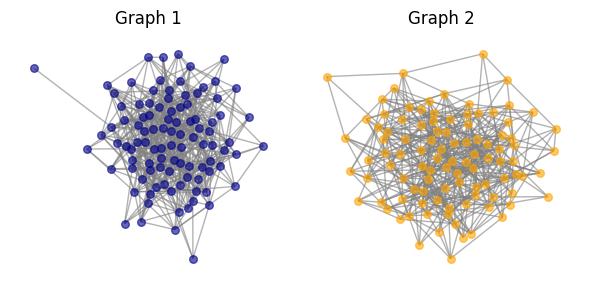

Distance between graph1 and graph2: 152.79


In [11]:
# Creating random graphs for comparison
graph1= nx.erdos_renyi_graph(100, 0.1)
graph2 = nx.erdos_renyi_graph(100, 0.1)
utils.plot_graphs(graph1, graph2, "Graph 1", "Graph 2")
# Using Comparator to find distance between graphs
comp = Comparator()
distance = comp.fit_transform(graph1, graph2)
print(f"Distance between graph1 and graph2: {distance:.2f}")

## Breakdown of Comparator Functionality with wee SCOTT Objects

Now that we have seen the big picture functionality of SCOTT with the `Comparator` class, we are going to dive into the internal workflow, as outlined in BagPipeline.

We will use the graph depicted in the BagPipeline as a demo graph. Let's grab it now.

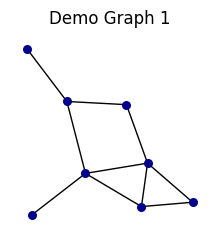

In [12]:
# Grabbing our demo graph
G = utils.get_demo_graph()
utils.plot_graph(G, "Demo Graph 1")

We can break the Comparator's functionality into substeps that use wee little `SCOTT` objects to help. Here's the plan:
#### Step 1 | Comparator **fit()**: Transform graphs or graph distributions into persistence diagrams via curvature filtration

Using `KILT`, we will:
1. Compute curvature (KILT's **fit()** method)
2. Execute a filtration with `GraphHomology`, yielding a persistence diagram (KILT's **transform()** method)

#### Step 2 | Comparator **transform()**: Convert persistence diagrams into vectorizations and compute distance

Using a subclass of `TopologicalDistance`, we will:
1. Convert persistence diagram into chosen vectorization (TopologicalDistance's **fit()** method)
2. Compute distance between vectorizations (TopologicalDistance's **transform()** method)  

For this tutorial, we will continue using the defaults. See our `custom_compare.ipynb` tutorial for options on how to customize this process.

## Step 1 | Using `KILT`

The `KILT` (Krvature-Informed Links and Topology) class is designed to compute a graph's curvature, assigning a curvature value to each edge.  
It then leverages the `GraphHomology` class to execute a filtration on graph edges based on these curvature values.

### Step 1.1 | Computing curvature

Default attributes for KILT object: {'measure': 'forman_curvature', 'weight': None, 'alpha': 0.0, 'prob_fn': None, '_G': None}
Curvature values: [ 1.  3. -1. -2.  2.  0. -3. -1. -1.  0.]


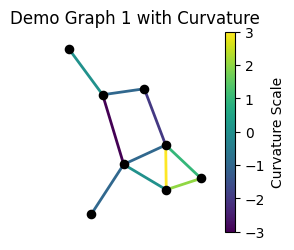

In [13]:
# Creating a KILT object with defaults
curv_obj = KILT()

# Printing attributes of KILT object (opportunity for customization)
print(f"Default attributes for KILT object: {vars(curv_obj)}")

# Calculate curvature
curv_obj.fit(graph=G)
    # Returns None, saves list of curvature values in .curvature attribute
    # Graph is copied and saved (with curvature values as edge attributes) under the ._G attribute

# Show curvature values
print(f"Curvature values: {curv_obj.curvature[:10]}")

# Plot curvature values
utils.plot_curvature(graph=curv_obj.G, title="Demo Graph 1 with Curvature")

### Step 1.2 | Executing Filtration with `GraphHomology`

Step 1.2 is all completed by using KILT's transform() method, but we are breaking it down for the sake of investigating the GraphHomology object.  
The GraphHomology object is responsible for completing the filtration of edges based on their curvature values.

In [14]:
# Create GraphHomology object
ph = GraphHomology(filter_attribute=curv_obj.measure)

# Compute curvature filtration
diagram = ph.calculate_persistent_homology(curv_obj.G)

# Investigate how we store a persistence diagram
print(diagram)

This is a PersistenceDiagram object with the following (birth, death) pairs: 
	H0:(-3.0, -3.0)(-2.0, -2.0)(-2.0, -1.0)(-1.0, -1.0)(0.0, 0.0)(0.0, 0.0)(1.0, 1.0)(-3.0, inf)
	H1:(3.0, 3.0)(2.0, 3.0)(-1.0, inf)
	


Now, we have successfully executed a curvature filtration, resulting in a persistence diagram.  
We can think of a persistence_diagram as the raw form of the data we get from doing a filtration.  

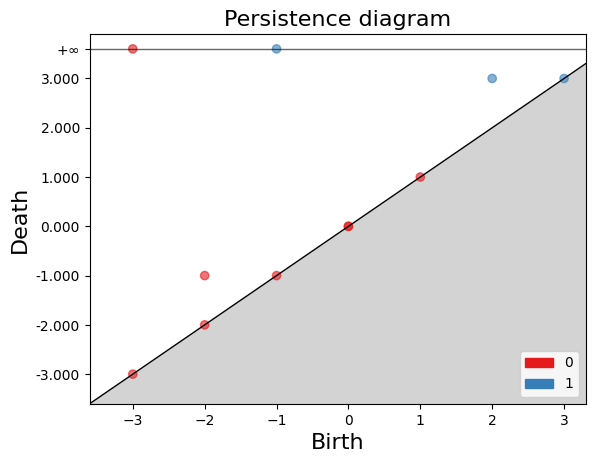

In [15]:
# Plotting persistence diagram
diagram.plot()

You'll notice this matches the persistence diagram in the BagPipeline.

## Step 2 | Using `TopologicalDistance` classes

`TopologicalDistance` is a parent class whose sublclasses handle how we compute distance between persistence diagrams.  
They have similar functionality, with the only difference being the type of vectorization they use:  
- `LandscapeDistance` converts persistence diagrams into **persistence landscapes**, averages over the distribution if necessary, then calculates distance between landscapes.
- `ImageDistance` converts persistence diagrams into **persistence images**, averages of the distribution if necessary, then calculates distance between images.

Let us introduce two persistence diagrams to compare now.

This is a PersistenceDiagram object with the following (birth, death) pairs: 
	H0:(0.0, 2.0)(1.0, 2.5)
	H1:(0.5, 2.0)(1.5, 2.5)
	
This is a PersistenceDiagram object with the following (birth, death) pairs: 
	H0:(0, 1)(1, 2)
	H1:(0.5, 2.5)(1.0, 3.0)
	


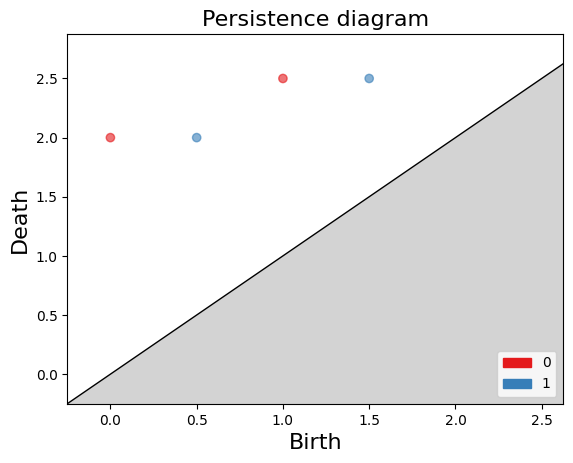

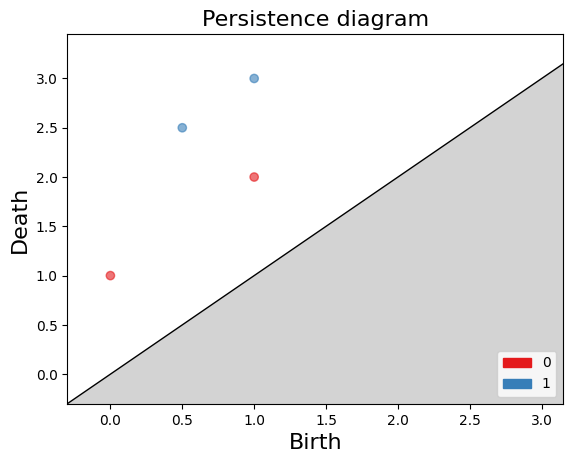

In [16]:
# Create toy persistence diagrams with H0, H1
pd1= PersistenceDiagram()
pd1.persistence_pts = {0: np.array([[0, 2], [1, 2.5]]), 1: np.array([[0.5, 2.0], [1.5, 2.5]])}
print(pd1)
pd1.plot()

pd2 = PersistenceDiagram()
pd2.persistence_pts = {0: np.array([[0, 1], [1, 2]]), 1: np.array([[0.5, 2.5], [1., 3]])}
print(pd2)
pd2.plot()

### Step 2.1 | Convert persistence diagrams into chosen vectorization

For each graph, we must convert its persistence diagram into our chosen vectorization.
Note that if a distribution is given, we aggregate the vectorizations of all persistence diagrams.

For this exercise we will use the default vectorization, persistence landscapes.

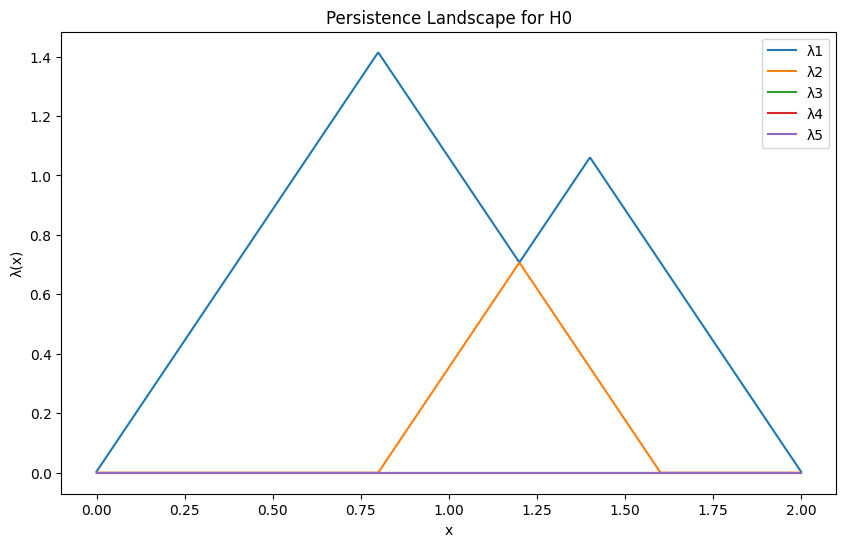

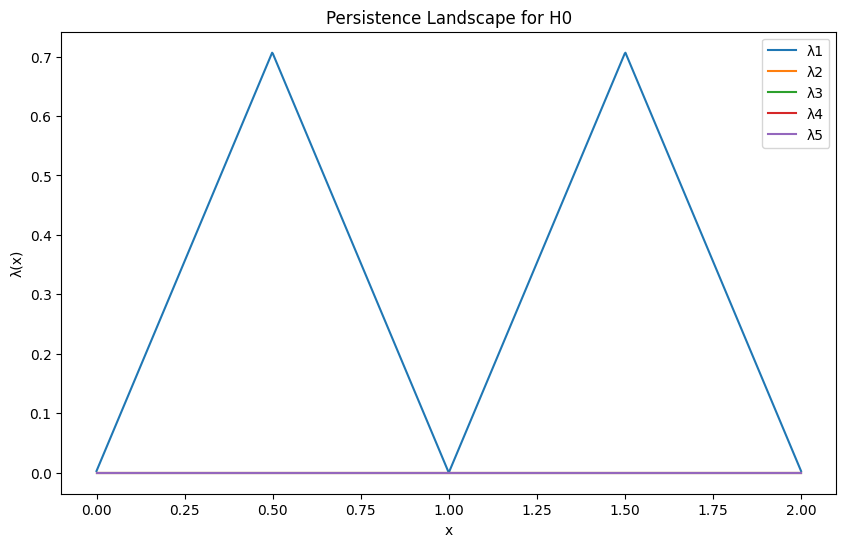

In [17]:
# Initialize LandscapeDistance object
LD = LandscapeDistance(pd1, pd2)

## Fit() method
# Convert persistence diagrams to landscapes
pl1, pl2 = LD._convert_to_landscape([pd1,pd2])
# Check that the conversion worked
assert isinstance(pl1, PersistenceLandscape)
assert isinstance(pl1, PersistenceLandscape)
# Average across distributions (not necessary here)                          
avg1 = LD._average_landscape([pl1])
avg2 = LD._average_landscape([pl2])
utils.plot_landscape(avg1)
utils.plot_landscape(avg2)

### Step 2.2 | Compute distance between vectorizations

Next, we subtract the persistence landscapes from one another, resulting in a persistence landscape that reflects the difference between the two. Finally, we compute the norm of this difference vectorization for each homology dimension (recall that the default norm is 2).

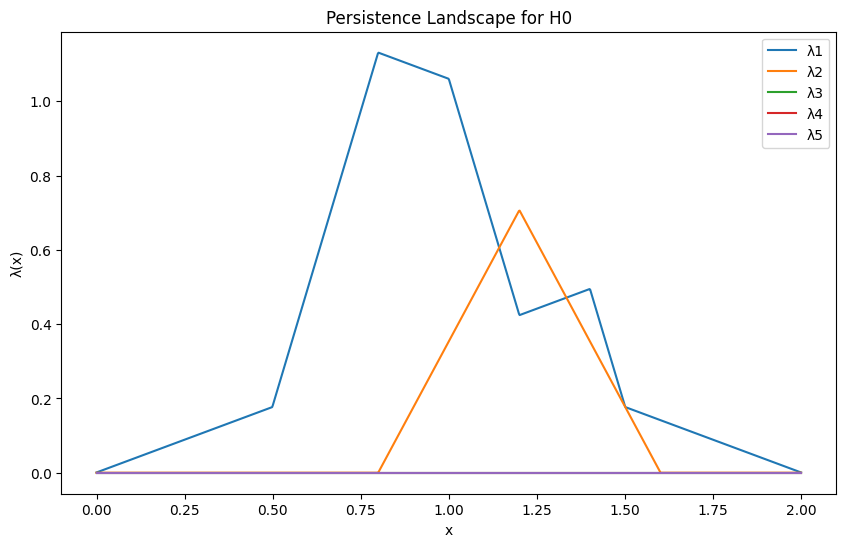

The distance between the two persistence landscapes is: 37.002


In [18]:
## Transform() method
# Subtract the landscapes from each other
difference_landscape = LD._subtract_landscapes(pl1, pl2)
utils.plot_landscape(difference_landscape)
# Compute the norm
distance = sum(LD.compute_norm(difference_landscape.functions[dim]) for dim in [0,1])
print(f"The distance between the two persistence landscapes is: {distance:.3f}")

## Well Done!

This concludes the tutorial.